In [1]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Visualize
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import time
from itertools import product
import xgboost
import gc
import warnings
warnings.filterwarnings("ignore")
#from xgboost import XGBRegressor
#from xgboost import plot_importance

In [16]:
data = pd.read_pickle('all_data.pkl')

In [3]:
print(data.shape)

(11128050, 44)


In [105]:
#data = pd.read_pickle('data_2.pkl')

In [106]:
#data = pd.read_pickle('data_3.pkl')
#print(data.shape)

In [9]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'shop_category', 'city_id', 'city_population', 'city_income',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_target_enc_lag_1',
       'date_item_target_enc_lag_1', 'date_shop_target_enc_lag_1',
       'date_item_shop_target_enc_lag_1', 'date_cat_target_enc_lag_1',
       'date_shop_cat_target_enc_lag_1', 'date_shop_type_target_enc_lag_1',
       'date_city_target_enc_lag_1', 'date_city_target_enc_lag_2',
       'date_city_target_enc_lag_3', 'date_item_city_target_enc_lag_1',
       'date_type_target_enc_lag_1', 'date_subtype_target_enc_lag_1',
       'delta_revenue_lag_1', 'month', 'weekends', 'item_first_interaction',
       'shop_item_sold_before', 'new_item_cat_avg_lag_1',
       'new_item_cat_avg_lag_2', 'new_item_cat_avg_lag_3',
       'new_item_shop_cat_avg_lag

In [10]:
data.drop(['new_item_shop_cat_avg_lag_2','new_item_shop_cat_avg_lag_3','item_cnt_month_lag_2','city_income','city_population',#,'shop_id', 
           'item_cnt_month_lag_3', 'item_cnt_month_lag_6','item_cnt_month_lag_12','date_city_target_enc_lag_2',
       'date_city_target_enc_lag_3'],axis = 1,inplace=True)

In [17]:
data = data[data.date_block_num >11]
X_train = data[(data.date_block_num < 30)].drop(['item_cnt_month'], axis=1)
Y_train = data[(data.date_block_num < 30)]['item_cnt_month']
X_valid = data[(data.date_block_num >= 30) & (data.date_block_num<=33)].drop(['item_cnt_month'], axis=1)
Y_valid = data[(data.date_block_num >= 30) & (data.date_block_num<=33)]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del data
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [18]:
gc.collect();

In [13]:
import lightgbm as lgb

In [14]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

In [21]:
# change train and val
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.73,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 0,
    'num_rounds': 5000,
    'early_stopping_rounds': 100,
    'verbose': 1
}

feature_name_indexes = [ 
                        'shop_id',
                        'city_id',
                        'type_code',
                        'subtype_code',
                        'shop_category',
                        'item_category_id', 
]
lgb_model = build_lgb_model(params, X_train, X_valid, Y_train, Y_valid, feature_name_indexes)

Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 1.08133	valid_1's rmse: 0.995665
[100]	training's rmse: 0.996852	valid_1's rmse: 0.932302
[150]	training's rmse: 0.938174	valid_1's rmse: 0.89085
[200]	training's rmse: 0.897078	valid_1's rmse: 0.86298
[250]	training's rmse: 0.867609	valid_1's rmse: 0.845219
[300]	training's rmse: 0.846248	valid_1's rmse: 0.833214
[350]	training's rmse: 0.830375	valid_1's rmse: 0.825697
[400]	training's rmse: 0.817951	valid_1's rmse: 0.820737
[450]	training's rmse: 0.808193	valid_1's rmse: 0.817162
[500]	training's rmse: 0.79997	valid_1's rmse: 0.81466
[550]	training's rmse: 0.793157	valid_1's rmse: 0.81255
[600]	training's rmse: 0.787258	valid_1's rmse: 0.811404
[650]	training's rmse: 0.782419	valid_1's rmse: 0.810336
[700]	training's rmse: 0.777482	valid_1's rmse: 0.809943
[750]	training's rmse: 0.773396	valid_1's rmse: 0.8095
[800]	training's rmse: 0.769792	valid_1's rmse: 0.809076
[850]	training's rmse: 0.766626	val

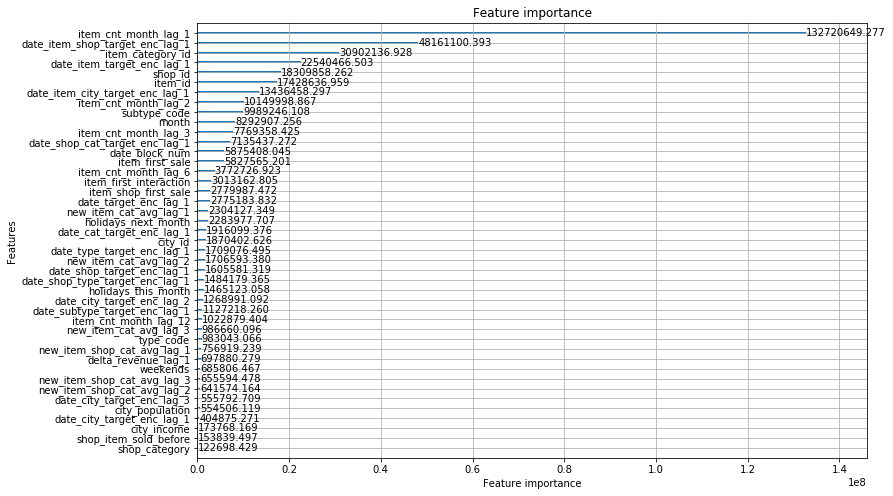

In [22]:
lgb.plot_importance(
    lgb_model, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [23]:
path = "/Users/williamchen/Documents/Kaggle/predict_future_sales/predict_future_sales_data/"
test = pd.read_csv(path+"test.csv",index_col='ID')
Y_pred = lgb_model.predict(X_valid).clip(0, 20)
Y_test = lgb_model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('test_lgb_git_val.csv', index=False)

In [123]:
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.73,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 0,
    'num_rounds': 1000,
    'early_stopping_rounds': 100,
    'verbose': 1
}

feature_name_indexes = [ 
                        'shop_id',
                        'city_id',
                        'type_code',
                        'subtype_code',
                        'shop_category',
                        'item_category_id', 
]
lgb_model = build_lgb_model(params, X_train, X_valid, Y_train, Y_valid, feature_name_indexes)

Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 1.07041	valid_1's rmse: 1.04981
[100]	training's rmse: 0.987561	valid_1's rmse: 0.993624
[150]	training's rmse: 0.930296	valid_1's rmse: 0.957501
[200]	training's rmse: 0.890335	valid_1's rmse: 0.935057
[250]	training's rmse: 0.861556	valid_1's rmse: 0.921895
[300]	training's rmse: 0.840908	valid_1's rmse: 0.913492
[350]	training's rmse: 0.825573	valid_1's rmse: 0.908251
[400]	training's rmse: 0.813577	valid_1's rmse: 0.905391
[450]	training's rmse: 0.803962	valid_1's rmse: 0.903487
[500]	training's rmse: 0.796105	valid_1's rmse: 0.903298
[550]	training's rmse: 0.789762	valid_1's rmse: 0.90326
[600]	training's rmse: 0.783906	valid_1's rmse: 0.903469
[650]	training's rmse: 0.778973	valid_1's rmse: 0.904082
Early stopping, best iteration is:
[584]	training's rmse: 0.785801	valid_1's rmse: 0.903004


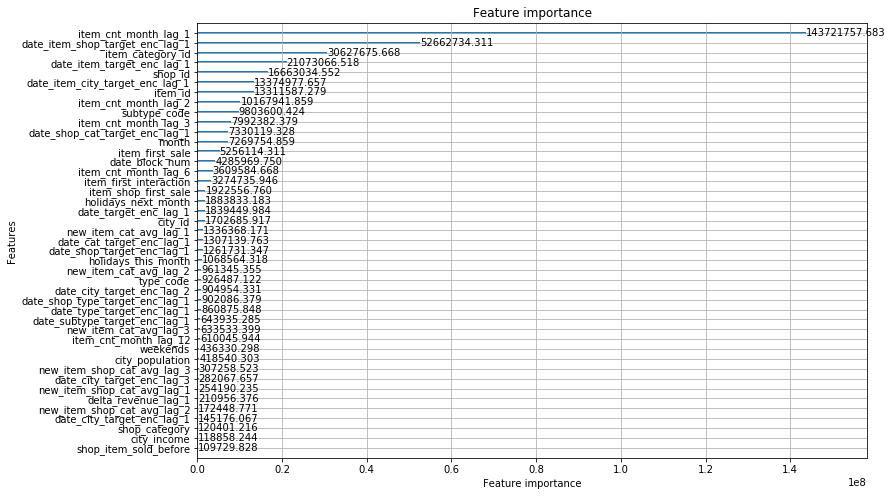

In [124]:
lgb.plot_importance(
    lgb_model, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [125]:
path = "/Users/williamchen/Documents/Kaggle/predict_future_sales/predict_future_sales_data/"
test = pd.read_csv(path+"test.csv",index_col='ID')
Y_pred = lgb_model.predict(X_valid).clip(0, 20)
Y_test = lgb_model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('test_lgb_git.csv', index=False)

In [286]:
data = data[data.date_block_num >11]
X_train = data[(data.date_block_num <= 33)].drop(['item_cnt_month'], axis=1)
Y_train = data[(data.date_block_num <= 33)]['item_cnt_month']
Y_train = Y_train.clip(0, 20)

In [287]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


In [288]:
cat_features = ['name2','name3','item_id', 'shop_id','month','shop_category','shop_city','item_category_id',
               'type_code','subtype_code','item_first_interaction','shop_item_sold_before']

In [289]:
params = {
    'max_depth' : np.arange(5,10,1),
    'num_leaves': np.arange(20,100,10),   
    'min_data_in_leaf':  np.arange(10,100,10),
    'feature_fraction': np.arange(0.3,1,0.1),
    'learning_rate': [0.005,0.01,0.03,0.05,0.1,0.3,0.5]
}
lgbm = lgb.LGBMRegressor(random_state=9,n_estimators = 60,silent=False,metric='rmse')#,
#                         max_depth = 20,num_leaves = 60,min_data_in_leaf = 60,feature_fraction=0.6,learning_rate=0.03)
time_split = TimeSeriesSplit(n_splits = 4)
lgb_search = RandomizedSearchCV(lgbm,param_distributions=params, 
                                random_state=9, n_iter=4, cv=time_split, verbose=1, n_jobs=-1, return_train_score=True)

In [290]:
%%time
lgb_search.fit(X_train, Y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  3.9min finished


CPU times: user 1min 44s, sys: 4.89 s, total: 1min 49s
Wall time: 4min 11s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
                   error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           metric='rmse', min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=60,
                                           n_jobs=-1, num_leaves=31,
                                           objectiv...
                   param_distributions={'feature_fraction': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.005, 0.01, 0.03,
                        